# Purpose

To carry out testing of the proposed pipeline to detect the tongue using OpenCV

Pipeline: Image > CLAHE > Image thresholding > detect contours of image > use contours to detect centre of tongue

Thereafter, we apply the SAM2 model on the image and see the results

In [39]:
# pip install if running on colab
# !pip install ultralytics --quiet

In [40]:
# If running on colab, uncomment bottom line in this cell
# zip the Samples folder, then manually upload to colab to unzip

# !unzip Samples.zip

Archive:  Samples.zip
replace Samples/sample_1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: Samples/sample_1.jpg    
  inflating: Samples/sample_2.jpg    
  inflating: Samples/sample_3.jpg    
  inflating: Samples/sample_4.jpg    
  inflating: Samples/sample_5.jpg    
  inflating: Samples/sample_6.jpg    
  inflating: Samples/sample_7.jpg    
  inflating: Samples/sample_8.jpg    
  inflating: Samples/sample_9.jpg    
  inflating: Samples/_classes.csv    


In [41]:
import cv2

import matplotlib.pyplot as plt

from PIL import Image
import numpy as np

from ultralytics import SAM

import torch

In [42]:
def find_tongue_center(image_path):
    '''
    Finds the center of the tongue. Process:
    1. read image, convert into grayscale
    2. Apply CLAHE to enhance image features
    3. Apply binary thresholding
    4. Look for contours in the thresholded image
    5. Get the largest contour in terms of area, then find its centroid by computing moments

    Args:
        image_path (str): path to the image

    Returns:
        list of ints: (x, y) coordinates of center of tongue. If unable to find center of tongue, entries will be
        [-1, -1] instead
    '''
    # Load the image
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Enhance contrast
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(gray)

    # Threshold the image
    _, binary = cv2.threshold(enhanced, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Find contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        # Find the largest contour
        tongue_contour = max(contours, key=cv2.contourArea)

        # Compute the center of the tongue
        M = cv2.moments(tongue_contour)
        if M["m00"] != 0:
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
        else:
            cx, cy = 0, 0

        # Visualize the result
        # result = image.copy()
        # cv2.drawContours(result, [tongue_contour], -1, (0, 255, 0), 2)
        # cv2.circle(result, (cx, cy), 5, (0, 0, 255), -1)
        # cv2.imwrite(f"./processed/{image_path[10:]}", result)
        # cv2.imshow("Detected Tongue Center", result)
        # cv2.waitKey(0)
        # cv2.destroyAllWindows()

        return [cx, cy]
    else:
        print(f"No contours found for image path: {image_path}")
        # return [-1, -1] to invalidate return value, and throw error if we access the values
        return [-1, -1]

In [43]:
coords = []

for i in range(1, 10):
    cx, cy = find_tongue_center(f"./Samples/sample_{i}.jpg")
    coords.append((cx, cy))

In [44]:
coords

[(318, 363),
 (320, 300),
 (380, 239),
 (301, 308),
 (334, 266),
 (254, 303),
 (324, 349),
 (312, 278),
 (300, 423)]

## Using SAM2 to segment the tongues

In [45]:
model = SAM("sam2.1_l.pt")

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# print out device we are working on
device

'cuda'

In [46]:
def segment(image, center):
    '''
    Uses the SAM2 model to segment the tongue out

    Args:
        image (PIL.Image): image as read from PIL image library
        center (list): list of coordinates for center of the tongue

    Returns:
        segmented_image (np.array): image after performing segmentation and masking
        mask_pil (np.array): image mask of the tongue
    '''
    image_np = np.array(image)

    # Segmentation: arbitrarily take 0, 0 as a point that does not contain the tongue
    results_pil = model(image_np, points=[center, [0, 0]], labels=[1, 0])

    # Get the mask from the results
    mask_pil = results_pil[0].masks.data[0].cpu().numpy()

    # Masking
    binary_mask = mask_pil > 0.5
    rgb_mask = np.repeat(binary_mask[:, :, np.newaxis], 3, axis=2)
    segmented_image = image_np * rgb_mask

    return segmented_image, mask_pil

In [47]:
# read images into a list of images
im_lst = []

for i in range(1, 10):
    im = Image.open(f"./Samples/sample_{i}.jpg")
    im_lst.append(im)

In [48]:
im_lst

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640>]

In [49]:
segmented_images = []
masks = []

for i in range(len(im_lst)):
  segmented, mask = segment(im_lst[i], coords[i])
  segmented_images.append(segmented)
  masks.append(mask)


0: 1024x1024 1 0, 1 1, 685.0ms
Speed: 6.7ms preprocess, 685.0ms inference, 0.7ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 1 0, 1 1, 651.0ms
Speed: 7.1ms preprocess, 651.0ms inference, 0.7ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 1 0, 1 1, 650.9ms
Speed: 6.9ms preprocess, 650.9ms inference, 0.7ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 1 0, 1 1, 654.7ms
Speed: 6.9ms preprocess, 654.7ms inference, 0.7ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 1 0, 1 1, 656.4ms
Speed: 6.4ms preprocess, 656.4ms inference, 0.8ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 1 0, 1 1, 658.1ms
Speed: 6.3ms preprocess, 658.1ms inference, 0.7ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 1 0, 1 1, 659.4ms
Speed: 6.2ms preprocess, 659.4ms inference, 0.7ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 1 0, 1 1, 655.7ms
Speed: 6.8ms preprocess, 655.7ms inference, 

Results on the sample images

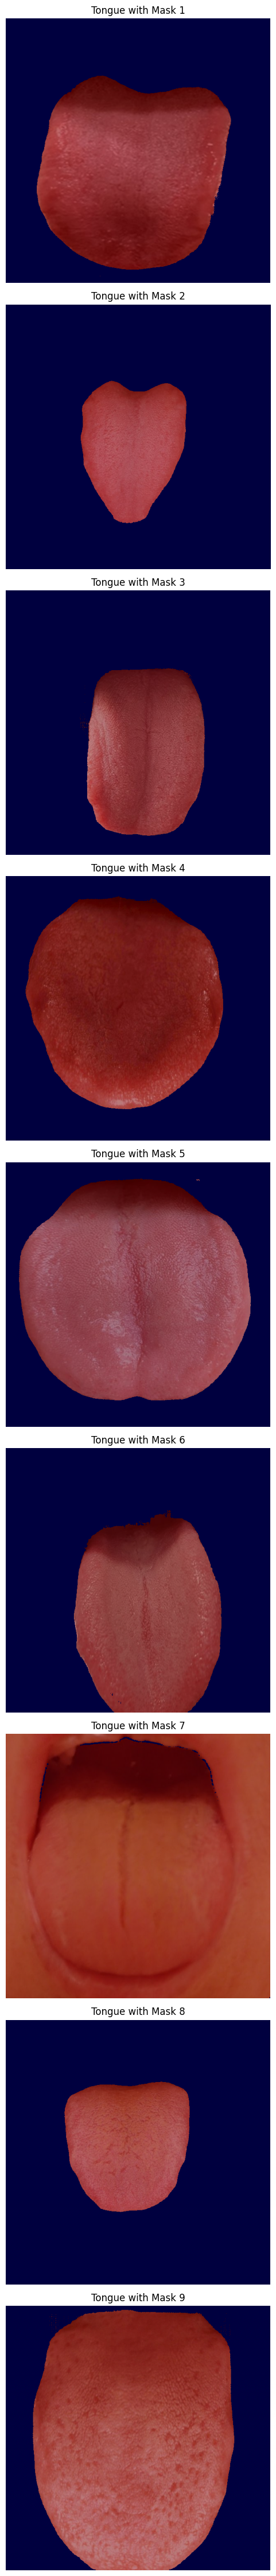

In [53]:
fig, axes = plt.subplots(len(segmented_images), 1, figsize=(10, len(segmented_images) * 5))

for i, (image, mask) in enumerate(zip(segmented_images, masks)):
    # Plot the original image
    axes[i].imshow(image, cmap='gray')

    # Overlay the mask on top of the image
    axes[i].imshow(mask, cmap='jet', alpha=0.5)  # Overlay mask with transparency
    # Formatting
    axes[i].axis('off')
    axes[i].set_title(f'Tongue with Mask {i + 1}')

plt.tight_layout()
plt.show()